# Stats

TODO:
OUTSIDE NOTEBOOK
- label more points
- save masks

## Setup

### Imports

In [106]:
import os
import matplotlib.pyplot as plt
import random
import imageio
import numpy as np
from amftrack.util.sys import storage_path

In [107]:
path = os.path.join(storage_path, "test_precise_1")
im_path = os.path.join(path, "slices.png")
label_path = os.path.join(path, "labels.npy")

In [108]:
im = imageio.imread(im_path)
print(im.shape)

(224, 120)


In [109]:
with open(label_path, 'rb') as f:
    label = np.load(f)
print(label.shape)

(224,)


In [110]:
label = np. expand_dims(label, axis =1)

In [111]:
label.shape

(224, 1)

## Visualisation

### Big edge

In [124]:
i = 68

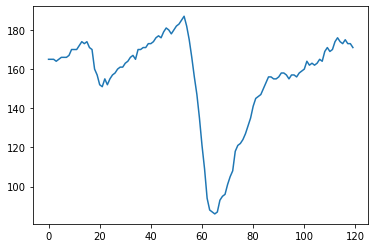

In [125]:
plt.plot(im[i,:])

In [123]:
label[i,:]

array([12.41270832])

### Medium edge

In [128]:
i = 12

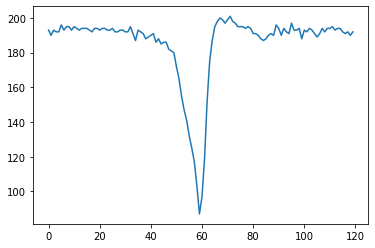

In [129]:
plt.plot(im[i,:])

In [130]:
label[i,:]

array([5.69865969])

### Small edge

In [131]:
i = 200

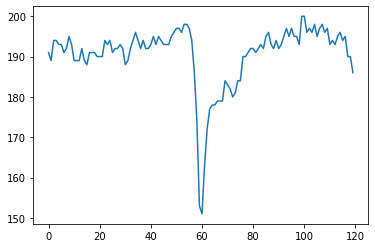

In [132]:
plt.plot(im[i,:])

In [133]:
label[i,:]

array([3.34934415])

## Data preparation

In [134]:
np.random.seed(11)

In [135]:
p = np.random.permutation(224)

In [137]:
training = p[:150]
test = p[150:]
print(len(training))
print(len(test))

150
74


In [138]:
train_feature = im[training, :]
train_label = label[training,0]
test_feature = im[test, :]
test_label = label[test, :]

In [139]:
test_feature.shape

(74, 120)

## Baseline

In [140]:
mean = np.mean(train_label)
final_score = np.mean(np.abs(test_label-mean))

In [141]:
final_score

1.5074212494126962

## First model

In [143]:
from amftrack.ml.width.models import first_model
from amftrack.ml.width.data_augmentation import data_augmentation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers

In [144]:
def model1():
    input = keras.Input(shape=(120, 1))
    scaling = keras.layers.Rescaling(1.0 / 122 - 1.)(input)
    conv1 = keras.layers.Conv1D(
        filters=640, kernel_size=12, strides=3, activation="relu", name="conv1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4),
    )(scaling)
    conv2 = keras.layers.Conv1D(
        filters=320,
        kernel_size=3,
        strides=3,
        activation="relu",
        name="conv2",
        kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4)
    )(conv1)
    flatten = tf.keras.layers.Flatten()(conv2)
    dense1 = keras.layers.Dense(640, activation="relu", name="dense1", kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4))(flatten)
    dense2 = keras.layers.Dense(320, activation="relu", name="dense2")(dense1)
    output = keras.layers.Dense(1, activation=None)(dense2)
    model = keras.Model(inputs=input, outputs=output)
    return model

In [147]:
model = model1()

In [148]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 1)]          0         
                                                                 
 rescaling_1 (Rescaling)     (None, 120, 1)            0         
                                                                 
 conv1 (Conv1D)              (None, 37, 640)           8320      
                                                                 
 conv2 (Conv1D)              (None, 12, 320)           614720    
                                                                 
 flatten_1 (Flatten)         (None, 3840)              0         
                                                                 
 dense1 (Dense)              (None, 640)               2458240   
                                                                 
 dense2 (Dense)              (None, 320)               2051

### Training

In [149]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])

In [159]:
history = model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=60,
    validation_split = 0.2
    )

Epoch 1/60
16/16 [==============================] - 1s 41ms/step - loss: 1.0283 - mean_absolute_error: 0.6580 - val_loss: 1.0111 - val_mean_absolute_error: 0.6576
Epoch 2/60
16/16 [==============================] - 1s 34ms/step - loss: 1.2011 - mean_absolute_error: 0.7523 - val_loss: 0.8402 - val_mean_absolute_error: 0.6007
Epoch 3/60
16/16 [==============================] - 1s 36ms/step - loss: 1.0667 - mean_absolute_error: 0.6970 - val_loss: 1.0960 - val_mean_absolute_error: 0.7762
Epoch 4/60
16/16 [==============================] - 1s 38ms/step - loss: 1.3400 - mean_absolute_error: 0.8003 - val_loss: 1.3544 - val_mean_absolute_error: 0.9257
Epoch 5/60
16/16 [==============================] - 1s 37ms/step - loss: 1.0431 - mean_absolute_error: 0.6885 - val_loss: 1.0237 - val_mean_absolute_error: 0.7442
Epoch 6/60
16/16 [==============================] - 1s 34ms/step - loss: 1.1285 - mean_absolute_error: 0.7216 - val_loss: 0.9505 - val_mean_absolute_error: 0.6369
Epoch 7/60
16/16 [====

16/16 [==============================] - 1s 34ms/step - loss: 0.7958 - mean_absolute_error: 0.5781 - val_loss: 1.2192 - val_mean_absolute_error: 0.6607
Epoch 52/60
16/16 [==============================] - 1s 34ms/step - loss: 0.7536 - mean_absolute_error: 0.5480 - val_loss: 2.0588 - val_mean_absolute_error: 1.2076
Epoch 53/60
16/16 [==============================] - 1s 34ms/step - loss: 0.8606 - mean_absolute_error: 0.6155 - val_loss: 1.0064 - val_mean_absolute_error: 0.6562
Epoch 54/60
16/16 [==============================] - 1s 39ms/step - loss: 0.7267 - mean_absolute_error: 0.5334 - val_loss: 1.1525 - val_mean_absolute_error: 0.7151
Epoch 55/60
16/16 [==============================] - 1s 41ms/step - loss: 0.6989 - mean_absolute_error: 0.5099 - val_loss: 1.0707 - val_mean_absolute_error: 0.6834
Epoch 56/60
16/16 [==============================] - 1s 35ms/step - loss: 0.8114 - mean_absolute_error: 0.5590 - val_loss: 1.2253 - val_mean_absolute_error: 0.7540
Epoch 57/60
16/16 [=========

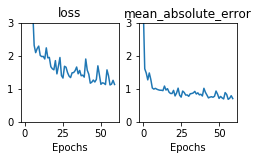

In [153]:
for i, key in enumerate(history.history.keys()):
    plt.subplot(2, 3, i+1)
    plt.plot(history.history[key])
    plt.title(key)
    plt.ylim(0, 3)
    plt.xlabel("Epochs")

In [154]:
model.evaluate(test_feature, test_label)

3/3 [==============================] - 0s 9ms/step - loss: 2.7546 - mean_absolute_error: 1.0736


[2.754633665084839, 1.0736197233200073]

## Cross validation

In [155]:
from sklearn.model_selection import KFold

n_split=3
history = []

for train, valid in KFold(n_split).split(training):
    
    train_feature = im[train, :]
    train_label = label[train,0]
    valid_feature = im[valid, :]
    valid_label = label[valid, :]

    model = model1()
    model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])
    
    history.append(model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=100,
    validation_data = (valid_feature, valid_label),
    ))

    print('Model evaluation ', model.evaluate(test_feature, test_label))

Epoch 1/100
20/20 [==============================] - 1s 44ms/step - loss: 46.0064 - mean_absolute_error: 4.7939 - val_loss: 13.5095 - val_mean_absolute_error: 2.1414
Epoch 2/100
20/20 [==============================] - 1s 35ms/step - loss: 5.4947 - mean_absolute_error: 1.6915 - val_loss: 11.6056 - val_mean_absolute_error: 1.8720
Epoch 3/100
20/20 [==============================] - 1s 35ms/step - loss: 5.4123 - mean_absolute_error: 1.7301 - val_loss: 9.7375 - val_mean_absolute_error: 2.4435
Epoch 4/100
20/20 [==============================] - 1s 35ms/step - loss: 3.9016 - mean_absolute_error: 1.3551 - val_loss: 13.8373 - val_mean_absolute_error: 3.3271
Epoch 5/100
20/20 [==============================] - 1s 35ms/step - loss: 4.3427 - mean_absolute_error: 1.4590 - val_loss: 9.7535 - val_mean_absolute_error: 2.5842
Epoch 6/100
20/20 [==============================] - 1s 35ms/step - loss: 4.5026 - mean_absolute_error: 1.5604 - val_loss: 8.7792 - val_mean_absolute_error: 1.6504
Epoch 7/100


Epoch 51/100
20/20 [==============================] - 1s 35ms/step - loss: 1.0598 - mean_absolute_error: 0.6931 - val_loss: 6.6705 - val_mean_absolute_error: 1.7941
Epoch 52/100
20/20 [==============================] - 1s 36ms/step - loss: 0.9413 - mean_absolute_error: 0.6262 - val_loss: 7.2806 - val_mean_absolute_error: 1.5027
Epoch 53/100
20/20 [==============================] - 1s 35ms/step - loss: 1.0039 - mean_absolute_error: 0.6719 - val_loss: 7.2150 - val_mean_absolute_error: 1.4920
Epoch 54/100
20/20 [==============================] - 1s 38ms/step - loss: 1.2457 - mean_absolute_error: 0.8061 - val_loss: 7.4865 - val_mean_absolute_error: 1.6591
Epoch 55/100
20/20 [==============================] - 1s 45ms/step - loss: 1.0285 - mean_absolute_error: 0.6701 - val_loss: 6.8658 - val_mean_absolute_error: 1.7426
Epoch 56/100
20/20 [==============================] - 1s 43ms/step - loss: 0.9212 - mean_absolute_error: 0.6157 - val_loss: 7.4228 - val_mean_absolute_error: 1.8587
Epoch 57/1

3/3 [==============================] - 0s 10ms/step - loss: 4.4643 - mean_absolute_error: 1.0938
Model evaluation  [4.464341640472412, 1.0938053131103516]
Epoch 1/100
20/20 [==============================] - 2s 49ms/step - loss: 42.9612 - mean_absolute_error: 4.7255 - val_loss: 9.1783 - val_mean_absolute_error: 2.5592
Epoch 2/100
20/20 [==============================] - 1s 36ms/step - loss: 6.3978 - mean_absolute_error: 1.7852 - val_loss: 5.9074 - val_mean_absolute_error: 1.5559
Epoch 3/100
20/20 [==============================] - 1s 42ms/step - loss: 5.1842 - mean_absolute_error: 1.5713 - val_loss: 6.6720 - val_mean_absolute_error: 1.7339
Epoch 4/100
20/20 [==============================] - 1s 45ms/step - loss: 4.9686 - mean_absolute_error: 1.5487 - val_loss: 8.1189 - val_mean_absolute_error: 2.0520
Epoch 5/100
20/20 [==============================] - 1s 46ms/step - loss: 4.3002 - mean_absolute_error: 1.5437 - val_loss: 5.7071 - val_mean_absolute_error: 1.4635
Epoch 6/100
20/20 [=====

Epoch 50/100
20/20 [==============================] - 1s 32ms/step - loss: 1.6782 - mean_absolute_error: 0.8078 - val_loss: 5.0559 - val_mean_absolute_error: 1.4581
Epoch 51/100
20/20 [==============================] - 1s 33ms/step - loss: 1.9267 - mean_absolute_error: 0.9713 - val_loss: 4.5771 - val_mean_absolute_error: 1.3780
Epoch 52/100
20/20 [==============================] - 1s 34ms/step - loss: 1.2703 - mean_absolute_error: 0.7637 - val_loss: 4.5291 - val_mean_absolute_error: 1.3438
Epoch 53/100
20/20 [==============================] - 1s 37ms/step - loss: 1.1661 - mean_absolute_error: 0.7039 - val_loss: 3.4538 - val_mean_absolute_error: 1.1395
Epoch 54/100
20/20 [==============================] - 1s 36ms/step - loss: 1.1478 - mean_absolute_error: 0.6849 - val_loss: 3.7555 - val_mean_absolute_error: 1.1785
Epoch 55/100
20/20 [==============================] - 1s 39ms/step - loss: 1.5564 - mean_absolute_error: 0.8772 - val_loss: 3.2185 - val_mean_absolute_error: 1.1541
Epoch 56/1

Epoch 100/100
3/3 [==============================] - 0s 12ms/step - loss: 2.1983 - mean_absolute_error: 0.9666
Model evaluation  [2.1982975006103516, 0.9665575623512268]
Epoch 1/100
20/20 [==============================] - 1s 48ms/step - loss: 26.1835 - mean_absolute_error: 3.8365 - val_loss: 3.2635 - val_mean_absolute_error: 1.2699
Epoch 2/100
20/20 [==============================] - 1s 38ms/step - loss: 7.7833 - mean_absolute_error: 1.9023 - val_loss: 2.2491 - val_mean_absolute_error: 1.0755
Epoch 3/100
20/20 [==============================] - 1s 40ms/step - loss: 6.0691 - mean_absolute_error: 1.6181 - val_loss: 2.2724 - val_mean_absolute_error: 1.0732
Epoch 4/100
20/20 [==============================] - 1s 33ms/step - loss: 6.1787 - mean_absolute_error: 1.8726 - val_loss: 8.9586 - val_mean_absolute_error: 2.7511
Epoch 5/100
20/20 [==============================] - 1s 35ms/step - loss: 6.4769 - mean_absolute_error: 1.8348 - val_loss: 1.5328 - val_mean_absolute_error: 0.8279
Epoch 6/1

Epoch 49/100
20/20 [==============================] - 1s 39ms/step - loss: 1.7991 - mean_absolute_error: 0.9614 - val_loss: 1.2539 - val_mean_absolute_error: 0.7874
Epoch 50/100
20/20 [==============================] - 1s 37ms/step - loss: 1.7317 - mean_absolute_error: 0.9438 - val_loss: 1.2930 - val_mean_absolute_error: 0.8364
Epoch 51/100
20/20 [==============================] - 1s 38ms/step - loss: 1.7533 - mean_absolute_error: 0.9242 - val_loss: 1.2749 - val_mean_absolute_error: 0.7526
Epoch 52/100
20/20 [==============================] - 1s 36ms/step - loss: 2.0385 - mean_absolute_error: 0.9852 - val_loss: 1.0456 - val_mean_absolute_error: 0.6867
Epoch 53/100
20/20 [==============================] - 1s 38ms/step - loss: 1.7393 - mean_absolute_error: 0.9204 - val_loss: 1.1942 - val_mean_absolute_error: 0.7564
Epoch 54/100
20/20 [==============================] - 1s 36ms/step - loss: 1.8198 - mean_absolute_error: 0.9443 - val_loss: 1.6773 - val_mean_absolute_error: 0.9714
Epoch 55/1

Epoch 99/100
20/20 [==============================] - 1s 37ms/step - loss: 1.2563 - mean_absolute_error: 0.7696 - val_loss: 1.9304 - val_mean_absolute_error: 1.1076
Epoch 100/100
3/3 [==============================] - 0s 9ms/step - loss: 1.3140 - mean_absolute_error: 0.8097
Model evaluation  [1.313973069190979, 0.8097116351127625]


(0, 20)

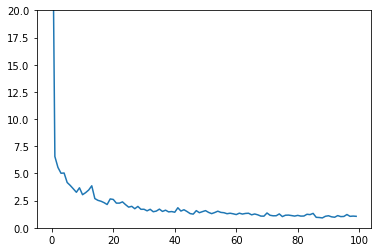

In [156]:
plt.plot(np.mean([history[i].history['loss'] for i in range(3)], axis = 0))
plt.ylim(0,20)

In [157]:
history[0].history.keys()

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])

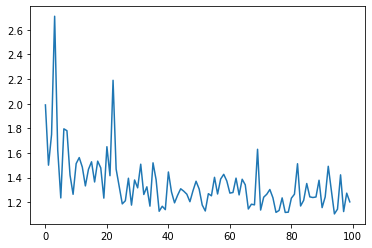

In [158]:
plt.plot(np.mean([history[i].history['val_mean_absolute_error'] for i in range(3)], axis = 0))

### Retrain best module

Epoch 1/60
16/16 [==============================] - 1s 42ms/step - loss: 1.8733 - mean_absolute_error: 1.0230 - val_loss: 1.2936 - val_mean_absolute_error: 0.8815
Epoch 2/60
16/16 [==============================] - 1s 41ms/step - loss: 1.1901 - mean_absolute_error: 0.7335 - val_loss: 1.8181 - val_mean_absolute_error: 1.0794
Epoch 3/60
16/16 [==============================] - 1s 44ms/step - loss: 0.9032 - mean_absolute_error: 0.6416 - val_loss: 1.4475 - val_mean_absolute_error: 0.8829
Epoch 4/60
16/16 [==============================] - 1s 37ms/step - loss: 1.0241 - mean_absolute_error: 0.7023 - val_loss: 1.2509 - val_mean_absolute_error: 0.8144
Epoch 5/60
16/16 [==============================] - 1s 33ms/step - loss: 1.0565 - mean_absolute_error: 0.7023 - val_loss: 1.3080 - val_mean_absolute_error: 0.7069
Epoch 6/60
16/16 [==============================] - 1s 33ms/step - loss: 1.0410 - mean_absolute_error: 0.7514 - val_loss: 1.6696 - val_mean_absolute_error: 1.0414
Epoch 7/60
16/16 [====

16/16 [==============================] - 1s 35ms/step - loss: 0.6189 - mean_absolute_error: 0.5673 - val_loss: 1.2313 - val_mean_absolute_error: 0.8888
Epoch 52/60
16/16 [==============================] - 1s 36ms/step - loss: 0.5941 - mean_absolute_error: 0.5472 - val_loss: 1.2782 - val_mean_absolute_error: 0.8971
Epoch 53/60
16/16 [==============================] - 1s 35ms/step - loss: 0.7027 - mean_absolute_error: 0.6020 - val_loss: 1.2958 - val_mean_absolute_error: 0.8415
Epoch 54/60
16/16 [==============================] - 1s 37ms/step - loss: 1.0769 - mean_absolute_error: 0.7158 - val_loss: 1.2133 - val_mean_absolute_error: 0.8240
Epoch 55/60
16/16 [==============================] - 1s 41ms/step - loss: 1.1807 - mean_absolute_error: 0.8410 - val_loss: 2.2492 - val_mean_absolute_error: 1.3271
Epoch 56/60
16/16 [==============================] - 1s 38ms/step - loss: 0.8511 - mean_absolute_error: 0.6986 - val_loss: 1.1279 - val_mean_absolute_error: 0.8059
Epoch 57/60
16/16 [=========

[1.4864717721939087, 0.9471707940101624]

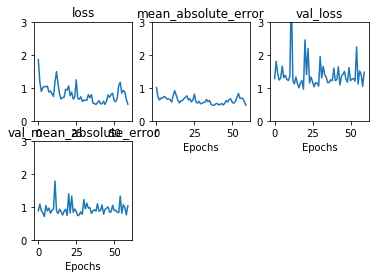

In [160]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.MeanSquaredError(name="mean_squared_error"),
    metrics=[tf.keras.metrics.mean_absolute_error])

history = model.fit(
    train_feature,
    train_label,
    batch_size=5,
    epochs=60,
    validation_split = 0.2
    )

for i, key in enumerate(history.history.keys()):
    plt.subplot(2, 3, i+1)
    plt.plot(history.history[key])
    plt.title(key)
    plt.ylim(0, 3)
    plt.xlabel("Epochs")

model.evaluate(test_feature, test_label)

# Brouillon

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

param_grid = [
  {'hidden_layer_sizes': [ (50,), (100,), (20,20,20), (100, 100), (100, 100, 20), (10, 10), (30, 30, 20)], 
   'learning_rate_init':[0.001, 0.01],
   'alpha': [0.1, 0.01, 0.001, 0.0001, 0.00001],
  }
 ]
print(param_grid)

# Cross-validation grid-search (for finding best possible accuracy)
clf = GridSearchCV(MLPRegressor(max_iter = 800,
                     early_stopping=True, 
                     n_iter_no_change = 10,
                     learning_rate_init = 0.0001,
                     alpha = 0.0001,
                     batch_size = 50,
                     hidden_layer_sizes=(40,40),
                     validation_fraction = 0.2,
                     random_state = 39,
                     verbose = 2), param_grid = param_grid, cv=3, scoring='neg_mean_squared_error')

clf.fit(X_train, y_train)

In [ ]:
from sklearn.model_selection import KFold

n_split=3

for train_index, test_index in KFold(n_split).split(X):
    x_train,x_test=X[train_index],X[test_index]
    y_train,y_test=Y[train_index],Y[test_index]

    model=create_model()
    model.fit(x_train, y_train,epochs=20)

    print('Model evaluation ',model.evaluate(x_test,y_test))

In [94]:
from sklearn.model_selection import KFold
KFold(3).split([1, 2, 3])

<generator object _BaseKFold.split at 0x7f6f829a92e0>